# MLP最適化

## 環境セットアップ

In [1]:
from google.colab import drive # driveを接続
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from __future__ import unicode_literals
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import
import pickle

In [3]:
# drive中の課題ファイルのあるディレクトリに移動
%cd /content/gdrive/My Drive/先端人工知能論Ⅰ/handson20210511/

from test_mlp import *  # テスト用

/content/gdrive/My Drive/先端人工知能論Ⅰ/handson20210511


In [4]:
import multiprocessing
multiprocessing.cpu_count()

2

In [5]:
import sys
import pickle
from PIL import Image, ImageDraw, ImageFont

## データセット読み込み

In [6]:
X, Y = fetch_openml('mnist_784', version=1, data_home="./data/", return_X_y=True)

In [7]:
X = X / 255.
Y = Y.astype("int")

In [8]:
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=2)
train_y = np.eye(10)[train_y].astype(np.int32)
test_y = np.eye(10)[test_y].astype(np.int32)
train_n = train_x.shape[0]
test_n = test_x.shape[0]

## モデルの実装

### 講義で扱った内容

In [9]:
class Sigmoid:
    def __init__(self):
        self.y = None
        
    def __call__(self, x):
        y = 1 / (1 + np.exp(-x))  # 順伝播計算
        self.y = y
        return y
    
    def backward(self):
        return self.y * (1 - self.y)  # 逆伝播計算

class ReLU:
    def __init__(self):
        self.x = None
        
    def __call__(self, x):
        self.x = x
        return x * (x>0)  # 順伝播計算
    
    def backward(self):
        return 1 * (self.x>0)  # 逆伝播計算

class Softmax:
    def __init__(self):
        self.y = None
        
    def __call__(self, x):
        exp_x = np.exp(x - x.max(axis=1, keepdims=True))
        y = exp_x / exp_x.sum(axis=1, keepdims=True)
        self.y = y
        return y

class Linear:
    def __init__(self, in_dim, out_dim, activation):
        self.W = np.random.uniform(low=-0.08, high=0.08, size=(in_dim, out_dim))
        self.b = np.zeros(out_dim)
        self.activation = activation()
        self.delta = None
        self.x = None
        self.dW = None
        self.db = None

    def __call__(self, x):
        # 順伝播計算
        self.x = x
        u = x @ self.W + self.b  # self.W, self.b, x を用いて u を計算しよう
        self.z = self.activation(u)
        return self.z
    
    def backward(self, dout):
        # 誤差計算
        self.delta = dout * self.activation.backward() # dout と活性化関数の逆伝播 (self.activation.backward()) を用いて delta を計算しよう
        dout = self.delta @ self.W.T  # self.delta, self.W を用いて 出力 o を計算しよう
        
        # 勾配計算
        self.dW = self.x.T @ self.delta  # dW を計算しよう
        self.db = np.ones(self.delta.shape[0]).reshape(1, -1) @ self.delta # db を計算しよう
        
        return dout

class MLP():
    def __init__(self, layers):
        self.layers = layers
        
    def train(self, x, t, lr):     
        # 1. 順伝播
        self.y = x
        for layer in self.layers:
            self.y = layer(self.y)  # 順伝播計算を順番に行い， 出力 y を計算しよう
        
        # 2. 損失関数の計算
        self.loss = np.sum(-t*np.log(self.y + 1e-7)) / len(x)
        
        # 3. 誤差逆伝播
        # 3.1. 最終層
        # 3.1.1. 最終層の誤差・勾配計算
        batchsize = len(self.layers[-1].x)
        delta = (self.y - t) / batchsize
        self.layers[-1].delta = delta
        self.layers[-1].dW = np.dot(self.layers[-1].x.T, self.layers[-1].delta)
        self.layers[-1].db = np.dot(np.ones(batchsize), self.layers[-1].delta)
        dout = np.dot(self.layers[-1].delta, self.layers[-1].W.T)
        
        # 3.1.2. 最終層のパラメータ更新
        self.layers[-1].W -= lr * self.layers[-1].dW # self.layers[-1].dW を用いて最終層の重みを更新しよう
        self.layers[-1].b -= lr * self.layers[-1].db # self.layers[-1].db を用いて最終層のバイアスを更新しよう
        
        # 3.2. 中間層
        for layer in self.layers[-2::-1]:

            # 3.2.1. 中間層の誤差・勾配計算
            dout = layer.backward(dout) # 逆伝播計算を順番に実行しよう
            
            # 3.2.2. パラメータの更新
            dW = layer.x.T @ layer.delta
            db = np.ones(delta.shape[0]) @ layer.delta
            layer.W -= lr * dW  # 各層の重みを更新
            layer.b -= lr * db  # 各層のバイアスを更新
            
        return self.loss

    def test(self, x, t):
        # 性能をテストデータで調べるために用いる
        # よって，誤差逆伝播は不要
        # 順伝播 (train関数と同様)
        self.y = x
        for layer in self.layers:
            self.y = layer(self.y)
        self.loss = np.sum(-t*np.log(self.y + 1e-7)) / len(x)
        return self.loss

### 追加実装

In [10]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
    
    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)
    __call__ = forward
    
    def backward(self, dout):
        return dout * self.mask

class MLP_withDropout(MLP):
    def __init__(self, layers, dropout_ratio=0):
        if 0 < dropout_ratio <= 1:
          self.layers = [layers[0]]
          for layer in layers[1:]:
            self.layers += [Dropout(dropout_ratio), layer]
        else:
          self.layers = layers
        
    def train(self, x, t, lr):   
        self.y = x
        for layer in self.layers:
            self.y = layer(self.y)
        
        self.loss = np.sum(-t*np.log(self.y + 1e-7)) / len(x)
        
        batchsize = len(self.layers[-1].x)
        delta = (self.y - t) / batchsize
        self.layers[-1].delta = delta
        self.layers[-1].dW = np.dot(self.layers[-1].x.T, self.layers[-1].delta)
        self.layers[-1].db = np.dot(np.ones(batchsize), self.layers[-1].delta)
        dout = np.dot(self.layers[-1].delta, self.layers[-1].W.T)
        
        self.layers[-1].W -= lr * self.layers[-1].dW # self.layers[-1].dW を用いて最終層の重みを更新しよう
        self.layers[-1].b -= lr * self.layers[-1].db # self.layers[-1].db を用いて最終層のバイアスを更新しよう
        
        for layer in self.layers[-2::-1]:
            dout = layer.backward(dout) # 逆伝播計算を順番に実行しよう
            if isinstance(layer, Dropout): 
              continue
            
            dW = layer.x.T @ layer.delta
            db = np.ones(delta.shape[0]) @ layer.delta
            layer.W -= lr * dW  # 各層の重みを更新
            layer.b -= lr * db  # 各層のバイアスを更新

        return self.loss

    def test(self, x, t):
        # 性能をテストデータで調べるために用いる
        # よって，誤差逆伝播は不要
        # 順伝播 (train関数と同様)
        self.y = x
        for layer in self.layers:
            if isinstance(layer, Dropout): 
              self.y = layer(self.y, train_flg=False)
            else:
              self.y = layer(self.y)

        self.loss = np.sum(-t*np.log(self.y + 1e-7)) / len(x)
        return self.loss

In [11]:
class Mish:
    def __init__(self):
        self.x = None
        
    def __call__(self, x):
        self.x = x
        return x * np.tanh(np.log(1+np.exp(x)))
    
    def backward(self):
        exp_x = np.exp(self.x)
        omega = 4*(self.x+1) + 4*exp_x**2 + exp_x**3 + (4*self.x+6)*exp_x
        delta = 2*exp_x + exp_x**2 + 2
        return exp_x * omega / delta**2

## 最適化

In [12]:
from IPython.display import display, clear_output
def test_hypparm(
        layer_unitsizes, activation_func, dropout_ratio,
        train_x, train_y,
        n_epoch, batchsize, lr, earlystop=False, eps=1e-5,
        verbose=False, save_name=None):
    layers = [Linear(784, layer_unitsizes[0], activation_func)]
    for i in range(1, len(layer_unitsizes)):
      layers += [Linear(layer_unitsizes[i-1], layer_unitsizes[i], activation_func)]
    layers += [Linear(layer_unitsizes[-1], 10, Softmax)]
    model = MLP_withDropout(layers, dropout_ratio)
    train_n = train_x.shape[0]

    if verbose:
      plt.ion()
      fig = plt.figure(figsize=(12,4))
      ax1 = fig.add_subplot(1, 2, 1)
      ax2 = fig.add_subplot(1, 2, 2)
      outputs = ""

    lastloss = 10**9
    scores = []

    for epoch in range(n_epoch):
      try:
        # train
        if verbose:
          print(f"epoch {epoch} | training...", end="")
        sum_loss = 0
        pred_y = []
        perm = np.random.permutation(train_n)      
        for i in range(0, train_n, batchsize):
            x = train_x[perm[i: i+batchsize]]
            t = train_y[perm[i: i+batchsize]]
            sum_loss += model.train(x, t, lr) * len(x)
            pred_y.extend(np.argmax(model.y, axis=1))
        
        train_loss = sum_loss / train_n
        train_accuracy = np.sum(np.eye(10)[pred_y] * train_y[perm]) / train_n
        
        # test
        if verbose:
          print(f" | testing...")
        sum_loss = 0
        pred_y = []      
        for i in range(0, test_n, batchsize):
            x = test_x[i: i+batchsize]
            t = test_y[i: i+batchsize]
            sum_loss += model.test(x, t) * len(x)
            pred_y.extend(np.argmax(model.y, axis=1))

        test_loss = sum_loss / test_n
        test_accuracy = np.sum(np.eye(10)[pred_y] * test_y) / test_n
        scores += [[train_loss, train_accuracy, test_loss, test_accuracy]]

      except KeyboardInterrupt as e:
        # manual stop
        print(f"learning interrupted in {epoch}th epoch")
        break

      # output status
      if verbose:
        outputs += 'epoch %d | ' % epoch
        outputs += 'Test loss %.3f, accuracy %.4f | ' %(train_loss, train_accuracy)
        outputs += f'Test loss {test_loss:.3f}, accuracy {test_accuracy:.4f}\n'

        ax1.cla()
        ax2.cla()
        s = np.array(scores)
        ax1.plot(range(s.shape[0]), s[:,0], marker="o", label="train loss")
        ax1.plot(range(s.shape[0]), s[:,2], marker="o", label="test loss")
        ax1.set_ylim(0, max(s[:,0][s.shape[0]//2:].max(), s[:,2][s.shape[0]//2:].max(), 0.1)*2)
        ax1.legend()
        ax2.plot(range(s.shape[0]), s[:,1], marker="o", label="train accuracy")
        ax2.plot(range(s.shape[0]), s[:,3], marker="o", label="test accuracy")
        ax2.set_ylim(1-(1-min(s[:,1][s.shape[0]//2:].min(), s[:,3][s.shape[0]//2:].min(), 0.95))*2, 1)
        ax2.legend()

        clear_output(wait = True)
        print(outputs.rstrip())
        display(fig) 

      # save current model
      if save_name is not None:
        with open(f"{save_name}.bin", mode="wb") as f:
          pickle.dump((model, scores), f)

      # early stop if loss doesn't update
      if earlystop and abs(lastloss-train_loss)<eps:
        print(f"early stopped.")
        break
      else:
        lastloss = train_loss
      # end epoch
    
    return model, scores

### finished

epoch 0 | Test loss 0.279, accuracy 0.9131Test loss 0.140, accuracy 0.9574
epoch 1 | Test loss 0.110, accuracy 0.9654Test loss 0.089, accuracy 0.9732
epoch 2 | Test loss 0.076, accuracy 0.9765Test loss 0.076, accuracy 0.9767
epoch 3 | Test loss 0.057, accuracy 0.9812Test loss 0.075, accuracy 0.9765
epoch 4 | Test loss 0.045, accuracy 0.9851Test loss 0.062, accuracy 0.9804
epoch 5 | Test loss 0.035, accuracy 0.9884Test loss 0.058, accuracy 0.9827
epoch 6 | Test loss 0.028, accuracy 0.9907Test loss 0.057, accuracy 0.9819
epoch 7 | Test loss 0.024, accuracy 0.9922Test loss 0.059, accuracy 0.9831
epoch 8 | Test loss 0.018, accuracy 0.9941Test loss 0.057, accuracy 0.9839
epoch 9 | Test loss 0.016, accuracy 0.9948Test loss 0.060, accuracy 0.9830
epoch 10 | Test loss 0.014, accuracy 0.9955Test loss 0.055, accuracy 0.9841
epoch 11 | Test loss 0.011, accuracy 0.9966Test loss 0.059, accuracy 0.9841
epoch 12 | Test loss 0.011, accuracy 0.9969Test loss 0.054, accuracy 0.9849
epoch 13 | Test loss 0

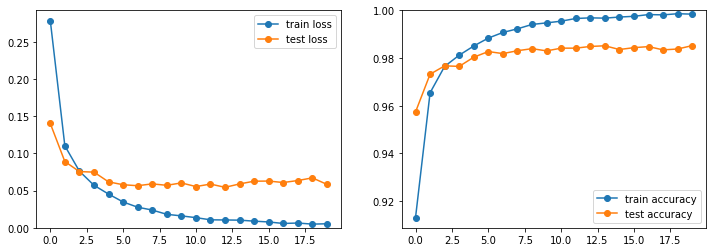

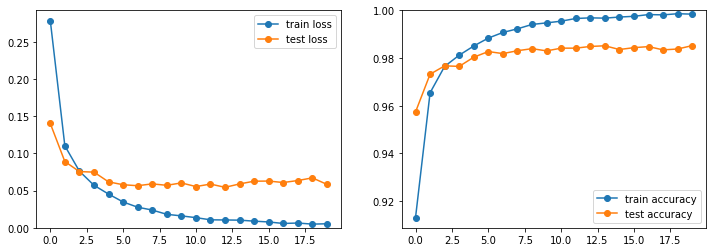

In [41]:
model,scores = test_hypparm(
        layer_unitsizes=[1000, 1000], activation_func=ReLU, dropout_ratio=0.2,
        n_epoch=20, batchsize=100, lr=0.5, earlystop=True, eps=1e-5,
        verbose=True, partial_save=True)

epoch 0 | Test loss 0.258, accuracy 0.9213 | Test loss 0.122, accuracy 0.9627
epoch 1 | Test loss 0.101, accuracy 0.9695 | Test loss 0.089, accuracy 0.9737
epoch 2 | Test loss 0.070, accuracy 0.9788 | Test loss 0.075, accuracy 0.9771
epoch 3 | Test loss 0.052, accuracy 0.9840 | Test loss 0.062, accuracy 0.9816
epoch 4 | Test loss 0.041, accuracy 0.9875 | Test loss 0.059, accuracy 0.9818
epoch 5 | Test loss 0.033, accuracy 0.9895 | Test loss 0.061, accuracy 0.9820


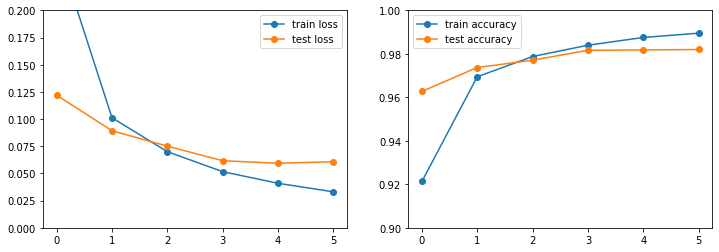

early stopped.


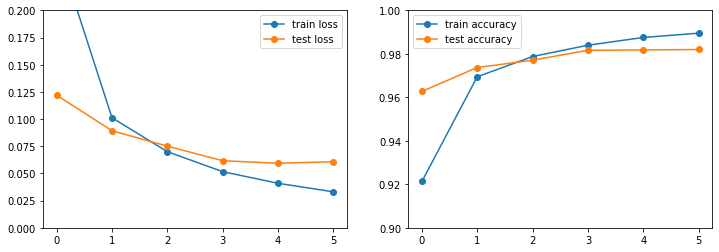

In [48]:
# earlystop test
model,scores = test_hypparm(
        layer_unitsizes=[1000], activation_func=ReLU, dropout_ratio=0.2,
        n_epoch=20, batchsize=100, lr=0.9, earlystop=True, eps=1e-2,
        verbose=True, save_name=None)

epoch 0 | Test loss 0.440, accuracy 0.8647 | Test loss 0.208, accuracy 0.9364
epoch 1 | Test loss 0.237, accuracy 0.9296 | Test loss 0.163, accuracy 0.9509
epoch 2 | Test loss 0.187, accuracy 0.9435 | Test loss 0.134, accuracy 0.9586
epoch 3 | Test loss 0.158, accuracy 0.9527 | Test loss 0.119, accuracy 0.9636
epoch 4 | Test loss 0.138, accuracy 0.9587 | Test loss 0.107, accuracy 0.9674
epoch 5 | Test loss 0.125, accuracy 0.9624 | Test loss 0.103, accuracy 0.9672
epoch 6 | Test loss 0.113, accuracy 0.9656 | Test loss 0.094, accuracy 0.9713
epoch 7 | Test loss 0.102, accuracy 0.9692 | Test loss 0.089, accuracy 0.9720
epoch 8 | Test loss 0.094, accuracy 0.9709 | Test loss 0.084, accuracy 0.9737
epoch 9 | Test loss 0.087, accuracy 0.9731 | Test loss 0.081, accuracy 0.9754
epoch 10 | Test loss 0.083, accuracy 0.9744 | Test loss 0.076, accuracy 0.9767
epoch 11 | Test loss 0.076, accuracy 0.9766 | Test loss 0.074, accuracy 0.9767
epoch 12 | Test loss 0.071, accuracy 0.9778 | Test loss 0.074,

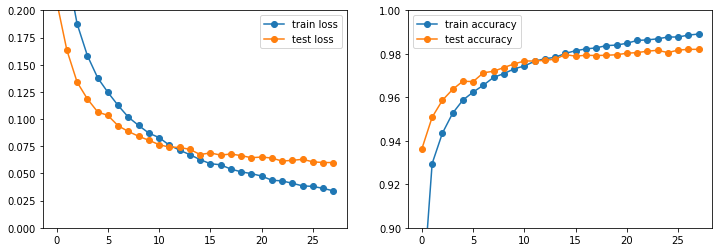

epoch 28 | training...

In [ ]:
model,scores = test_hypparm(
        [2000, 2000, 2000, 2000, 2000], Mish, 0.1,
        n_epoch=100, batchsize=100, lr=0.01, earlystop=True, eps=1e-5,
        verbose=True, save_name="2000x5_Mish_0.1_0.01")

In [ ]:
model,scores = test_hypparm(
        [2000, 2000, 2000, 2000, 2000], Mish, 0.2,
        n_epoch=100, batchsize=100, lr=0.01, earlystop=True, eps=1e-5,
        verbose=True, save_name="2000x5_Mish_0.2_0.01")

In [ ]:
model,scores = test_hypparm(
        [2000, 2000, 2000, 2000, 2000], Mish, 0.4,
        n_epoch=100, batchsize=100, lr=0.01, earlystop=True, eps=1e-5,
        verbose=True, save_name="2000x5_Mish_0.4_0.01")

### 水増しノート

In [12]:
from PIL import Image, ImageDraw, ImageFont
im = Image.fromarray((train_x[2].reshape(28, 28)*2**8//1).astype(np.uint8), "L")
im

36828


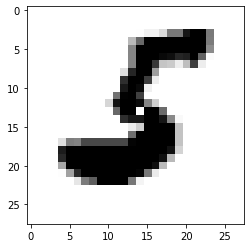

37141


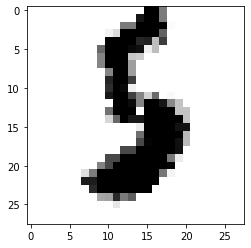

30673


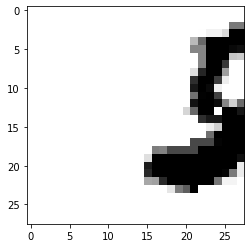

35270


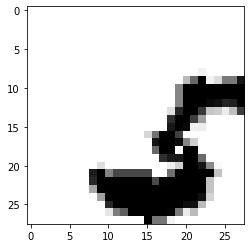

In [13]:
plt.imshow(np.asarray(im),  cmap='gray_r')
print(np.asarray(im).sum())
plt.show()

plt.imshow(np.asarray(im.rotate(30)),  cmap='gray_r')
print(np.asarray(im.rotate(30)).sum())
plt.show()

plt.imshow(np.asarray(im.rotate(10, translate=(10,0))),  cmap='gray_r')
print(np.asarray(im.rotate(10, translate=(10,0))).sum())
plt.show()

plt.imshow(np.asarray(im.rotate(-10, translate=(5,5))),  cmap='gray_r')
print(np.asarray(im.rotate(-10, translate=(5,5))).sum())
plt.show()

In [14]:
new_train_x = []
new_train_y = []
for arr,lbl in zip(train_x[:3], train_y[:3]):
  im = Image.fromarray((arr.reshape(28, 28)*2**8//1).astype(np.uint8), "L")
  for _ in range(10):
    t, x, y = [np.random.randint(-5, 6) for _ in range(3)]
    new_train_x.append(np.asarray(im.rotate(t, translate=(x, y))).ravel()/2**8)
    new_train_y.append(lbl)
new_train_x = np.asarray(new_train_x)
new_train_y = np.asarray(new_train_y)

In [15]:
new_train_x = []
new_train_y = []
for arr,lbl in zip(train_x, train_y):
  im = Image.fromarray((arr.reshape(28, 28)*2**8//1).astype(np.uint8), "L")
  for _ in range(10):
    t, x, y = [np.random.randint(-5, 6) for _ in range(3)]
    new_train_x.append(np.asarray(im.rotate(t, translate=(x, y))).ravel()/2**8)
    new_train_y.append(lbl)
new_train_x = np.asarray(new_train_x)
new_train_y = np.asarray(new_train_y)

In [ ]:
sys.getsizeof(new_train_x)/(1024**3) # GB

In [20]:
np.savez("augmented_inputs.npz", new_train_x, new_train_y)

epoch 0 | Test loss 0.514, accuracy 0.8402 | Test loss 0.129, accuracy 0.9624
epoch 1 | Test loss 0.231, accuracy 0.9293 | Test loss 0.094, accuracy 0.9702
epoch 2 | Test loss 0.174, accuracy 0.9459 | Test loss 0.078, accuracy 0.9756
epoch 3 | Test loss 0.142, accuracy 0.9552 | Test loss 0.068, accuracy 0.9779
epoch 4 | Test loss 0.122, accuracy 0.9616 | Test loss 0.062, accuracy 0.9801
epoch 5 | Test loss 0.106, accuracy 0.9664 | Test loss 0.061, accuracy 0.9812
epoch 6 | Test loss 0.093, accuracy 0.9704 | Test loss 0.058, accuracy 0.9818
epoch 7 | Test loss 0.083, accuracy 0.9735 | Test loss 0.054, accuracy 0.9835
epoch 8 | Test loss 0.075, accuracy 0.9763 | Test loss 0.054, accuracy 0.9836
epoch 9 | Test loss 0.068, accuracy 0.9780 | Test loss 0.051, accuracy 0.9849
epoch 10 | Test loss 0.061, accuracy 0.9807 | Test loss 0.052, accuracy 0.9840
epoch 11 | Test loss 0.056, accuracy 0.9820 | Test loss 0.051, accuracy 0.9847
epoch 12 | Test loss 0.052, accuracy 0.9836 | Test loss 0.051,

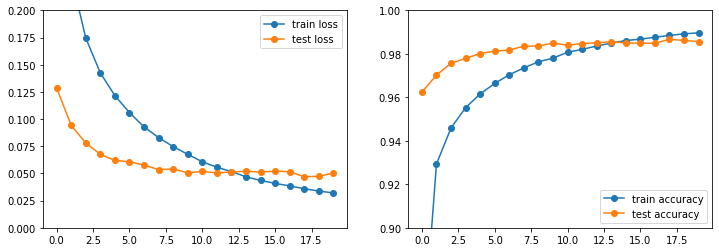

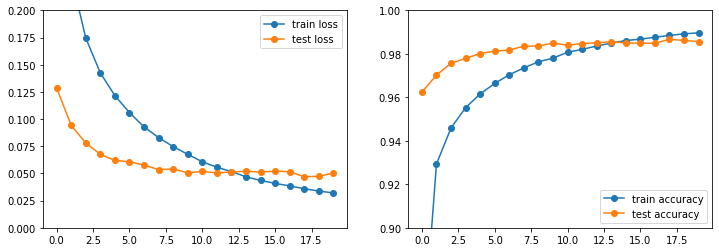

In [32]:
model,scores = test_hypparm(
        layer_unitsizes=[1000, 1000], activation_func=ReLU, dropout_ratio=0.2,
        train_x=new_train_x, train_y=new_train_y,
        n_epoch=20, batchsize=100, lr=0.1, earlystop=True, eps=1e-5,
        verbose=True, save_name="augmented_ReLU_1000x2_0.2_0.1")

### 一通りできた

In [13]:
def make_MLP_model(layer_unitsizes, activation_func, dropout_ratio):
    if layer_unitsizes==[]:
      return MLP([Linear(784, 10, Softmax)])
    layers = [Linear(784, layer_unitsizes[0], activation_func)]
    for i in range(1, len(layer_unitsizes)):
      layers += [Linear(layer_unitsizes[i-1], layer_unitsizes[i], activation_func)]
    layers += [Linear(layer_unitsizes[-1], 10, Softmax)]
    model = MLP_withDropout(layers, dropout_ratio)
    return model
def zoom_at(img, x, y, zoom):
    w, h = img.size
    zoom2 = zoom * 2
    img = img.crop((x - w / zoom2, y - h / zoom2, 
                    x + w / zoom2, y + h / zoom2))
    return img.resize((w, h), Image.LANCZOS)
# 増やしすぎるとMLEでクラッシュするので注意
def augment_images(train_x, train_y, magnification, include_original=True):
    new_train_x = []
    new_train_y = []
    for arr,lbl in zip(train_x, train_y):
      if include_original:
        new_train_x.append(arr)
        new_train_y.append(lbl)
      im = Image.fromarray((arr.reshape(28, 28)*2**8//1).astype(np.uint8), "L")
      for _ in range((magnification-1) if include_original else magnification):
        z = 0.8+np.random.rand()*0.4
        t, x, y = (np.random.randint(-5,6,size=3)/1.2//1).astype(np.int)
        newim = np.asarray(zoom_at(im, 28//2, 28//2, z).rotate(t, translate=(x, y))).ravel()/2**8
        new_train_x.append(newim)
        new_train_y.append(lbl)
    new_train_x = np.asarray(new_train_x)
    new_train_y = np.asarray(new_train_y)
    return new_train_x, new_train_y

In [14]:
from IPython.display import display, clear_output
def test_model(
        model, train_x, train_y, test_x, test_y, 
        n_epoch, batchsize, lr, earlystop=False, eps=1e-5,
        verbose=False, save_name=None):
    train_n = train_x.shape[0]

    if verbose:
      plt.ion()
      fig = plt.figure(figsize=(12,4))
      ax1 = fig.add_subplot(1, 2, 1)
      ax2 = fig.add_subplot(1, 2, 2)
      outputs = ""

    lastloss = 10**9
    scores = []

    for epoch in range(n_epoch):
      try:
        # train
        if verbose:
          print(f"epoch {epoch} | training...", end="")
        sum_loss = 0
        pred_y = []
        perm = np.random.permutation(train_n)      
        for i in range(0, train_n, batchsize):
            x = train_x[perm[i: i+batchsize]]
            t = train_y[perm[i: i+batchsize]]
            sum_loss += model.train(x, t, lr) * len(x)
            pred_y.extend(np.argmax(model.y, axis=1))
        
        train_loss = sum_loss / train_n
        train_accuracy = np.sum(np.eye(10)[pred_y] * train_y[perm]) / train_n
        
        # test
        if verbose:
          print(f" | testing...")
        sum_loss = 0
        pred_y = []      
        for i in range(0, test_n, batchsize):
            x = test_x[i: i+batchsize]
            t = test_y[i: i+batchsize]
            sum_loss += model.test(x, t) * len(x)
            pred_y.extend(np.argmax(model.y, axis=1))

        test_loss = sum_loss / test_n
        test_accuracy = np.sum(np.eye(10)[pred_y] * test_y) / test_n
        scores += [[train_loss, train_accuracy, test_loss, test_accuracy]]

      except KeyboardInterrupt as e:
        # manual stop
        print(f"learning interrupted in {epoch}th epoch")
        break

      # output status
      if verbose:
        outputs += 'epoch %d | ' % epoch
        outputs += 'Train loss %.3f, accuracy %.4f | ' %(train_loss, train_accuracy)
        outputs += f'Test loss {test_loss:.3f}, accuracy {test_accuracy:.4f}\n'

        ax1.cla()
        ax2.cla()
        s = np.array(scores)
        ax1.plot(range(s.shape[0]), s[:,0], marker="o", label="train loss")
        ax1.plot(range(s.shape[0]), s[:,2], marker="o", label="test loss")
        ax1.set_ylim(0, max(s[:,0][s.shape[0]//2:].max(), s[:,2][s.shape[0]//2:].max(), 0.1)*2)
        ax1.legend()
        ax2.plot(range(s.shape[0]), s[:,1], marker="o", label="train accuracy")
        ax2.plot(range(s.shape[0]), s[:,3], marker="o", label="test accuracy")
        ax2.set_ylim(1-(1-min(s[:,1][s.shape[0]//2:].min(), s[:,3][s.shape[0]//2:].min(), 0.95))*2, 1)
        ax2.legend()

        clear_output(wait = True)
        print(outputs.rstrip())
        display(fig) 

      # save current model
      if save_name is not None:
        with open(f"{save_name}.bin", mode="wb") as f:
          pickle.dump((model, scores), f)

      # early stop if loss doesn't update
      if earlystop and abs(lastloss-train_loss)<eps:
        print(f"early stopped.")
        break
      else:
        lastloss = train_loss
      # end epoch
    
    return model, scores

### finished

In [16]:
%%time
model = make_MLP_model([1000, 1000], Mish, 0.4)
new_train_x, new_train_y = augment_images(train_x, train_y, 10)

CPU times: user 1min 17s, sys: 6.12 s, total: 1min 23s
Wall time: 1min 23s


epoch 0 | Test loss 0.455, accuracy 0.8539 | Test loss 0.069, accuracy 0.9788
epoch 1 | Test loss 0.215, accuracy 0.9315 | Test loss 0.049, accuracy 0.9842
epoch 2 | Test loss 0.171, accuracy 0.9452 | Test loss 0.043, accuracy 0.9878
epoch 3 | Test loss 0.147, accuracy 0.9523 | Test loss 0.037, accuracy 0.9893
epoch 4 | Test loss 0.132, accuracy 0.9570 | Test loss 0.037, accuracy 0.9886
epoch 5 | Test loss 0.121, accuracy 0.9607 | Test loss 0.034, accuracy 0.9894
epoch 6 | Test loss 0.111, accuracy 0.9634 | Test loss 0.035, accuracy 0.9899
epoch 7 | Test loss 0.104, accuracy 0.9657 | Test loss 0.033, accuracy 0.9898
epoch 8 | Test loss 0.098, accuracy 0.9676 | Test loss 0.033, accuracy 0.9905
epoch 9 | Test loss 0.093, accuracy 0.9695 | Test loss 0.033, accuracy 0.9899
epoch 10 | Test loss 0.089, accuracy 0.9706 | Test loss 0.035, accuracy 0.9904
epoch 11 | Test loss 0.084, accuracy 0.9719 | Test loss 0.034, accuracy 0.9905
epoch 12 | Test loss 0.081, accuracy 0.9730 | Test loss 0.035,

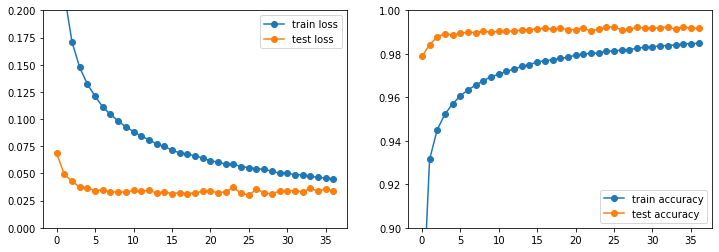

epoch 37 | training...

In [ ]:
%%time
model, scores = test_model(model, new_train_x, new_train_y, test_x, test_y,
                           40, 100, 0.5,
                           earlystop=True, verbose=True, save_name="augmentedx10_Mish_1000x2_0.4_0.5")

In [19]:
with open("augmentedx10_Mish_1000x2_0.4_0.5.bin", mode="rb") as f:
  model, scores = pickle.load(f)

(0.026348372738365763, 0.2)

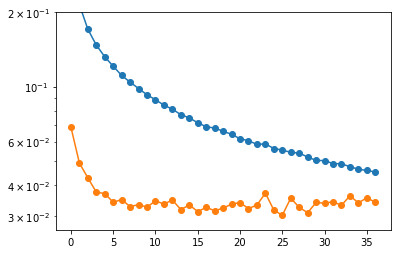

In [24]:
scores = np.asarray(scores)

plt.plot(range(scores.shape[0]), scores[:,0], marker="o", label="train loss")
plt.plot(range(scores.shape[0]), scores[:,2], marker="o", label="test loss")
plt.yscale("log")
plt.ylim(None, 0.2)

(0.98, 1.0)

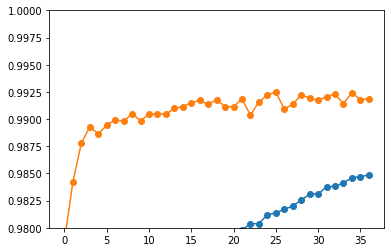

In [30]:
plt.plot(range(scores.shape[0]), scores[:,1], marker="o", label="train loss")
plt.plot(range(scores.shape[0]), scores[:,3], marker="o", label="test loss")
plt.ylim(0.98, 1)

In [31]:
%%time
model = make_MLP_model([1000, 1000], Mish, 0.5)
new_train_x, new_train_y = augment_images(train_x, train_y, 15)

CPU times: user 1min 59s, sys: 10.8 s, total: 2min 10s
Wall time: 2min 10s


In [32]:
%whos

Variable           Type               Data/Info
-----------------------------------------------
Dropout            type               <class '__main__.Dropout'>
Image              module             <module 'PIL.Image' from <...>t-packages/PIL/Image.py'>
ImageDraw          module             <module 'PIL.ImageDraw' f<...>ckages/PIL/ImageDraw.py'>
ImageFont          module             <module 'PIL.ImageFont' f<...>ckages/PIL/ImageFont.py'>
Linear             type               <class '__main__.Linear'>
MLP                type               <class '__main__.MLP'>
MLP_withDropout    type               <class '__main__.MLP_withDropout'>
Mish               type               <class '__main__.Mish'>
ReLU               type               <class '__main__.ReLU'>
Sigmoid            type               <class '__main__.Sigmoid'>
Softmax            type               <class '__main__.Softmax'>
X                  ndarray            70000x784: 54880000 elems, type `float64`, 439040000 bytes (418.701

epoch 0 | Train loss 0.450, accuracy 0.8552 | Test loss 0.065, accuracy 0.9796
epoch 1 | Train loss 0.225, accuracy 0.9279 | Test loss 0.053, accuracy 0.9831
epoch 2 | Train loss 0.184, accuracy 0.9408 | Test loss 0.043, accuracy 0.9864
epoch 3 | Train loss 0.162, accuracy 0.9478 | Test loss 0.038, accuracy 0.9881
epoch 4 | Train loss 0.147, accuracy 0.9521 | Test loss 0.037, accuracy 0.9886
epoch 5 | Train loss 0.137, accuracy 0.9556 | Test loss 0.033, accuracy 0.9899
epoch 6 | Train loss 0.128, accuracy 0.9586 | Test loss 0.033, accuracy 0.9891
epoch 7 | Train loss 0.122, accuracy 0.9603 | Test loss 0.033, accuracy 0.9896
epoch 8 | Train loss 0.116, accuracy 0.9621 | Test loss 0.029, accuracy 0.9909
epoch 9 | Train loss 0.112, accuracy 0.9637 | Test loss 0.031, accuracy 0.9906
epoch 10 | Train loss 0.108, accuracy 0.9648 | Test loss 0.029, accuracy 0.9912
epoch 11 | Train loss 0.105, accuracy 0.9657 | Test loss 0.029, accuracy 0.9914
epoch 12 | Train loss 0.102, accuracy 0.9666 | Tes

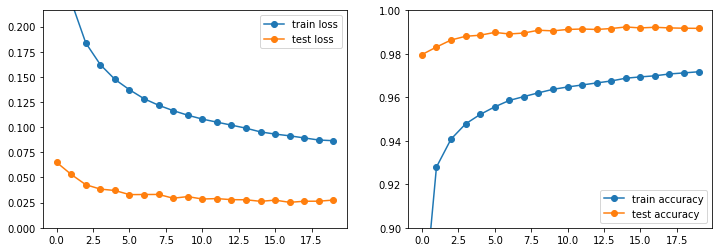

epoch 20 | training...

In [ ]:
%%time
model, scores = test_model(model, new_train_x, new_train_y, test_x, test_y,
                           40, 100, 0.5,
                           earlystop=True, verbose=True, save_name="augmentedx15_Mish_1000x2_0.5_0.5")

### Linear classifier

epoch 0 | Train loss 0.545, accuracy 0.8611 | Test loss 0.379, accuracy 0.8989
epoch 1 | Train loss 0.362, accuracy 0.9009 | Test loss 0.338, accuracy 0.9063
epoch 2 | Train loss 0.333, accuracy 0.9079 | Test loss 0.322, accuracy 0.9097
epoch 3 | Train loss 0.318, accuracy 0.9122 | Test loss 0.310, accuracy 0.9130
epoch 4 | Train loss 0.308, accuracy 0.9141 | Test loss 0.304, accuracy 0.9141
epoch 5 | Train loss 0.301, accuracy 0.9160 | Test loss 0.298, accuracy 0.9174
epoch 6 | Train loss 0.296, accuracy 0.9177 | Test loss 0.294, accuracy 0.9169
epoch 7 | Train loss 0.292, accuracy 0.9187 | Test loss 0.292, accuracy 0.9178
epoch 8 | Train loss 0.288, accuracy 0.9203 | Test loss 0.289, accuracy 0.9176
epoch 9 | Train loss 0.285, accuracy 0.9204 | Test loss 0.287, accuracy 0.9203
epoch 10 | Train loss 0.282, accuracy 0.9217 | Test loss 0.285, accuracy 0.9196
epoch 11 | Train loss 0.280, accuracy 0.9222 | Test loss 0.285, accuracy 0.9189
epoch 12 | Train loss 0.278, accuracy 0.9226 | Tes

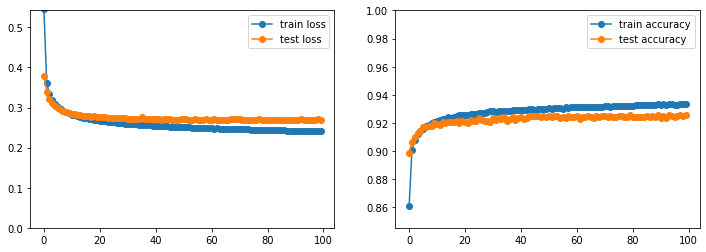

CPU times: user 2min 28s, sys: 1min 6s, total: 3min 34s
Wall time: 2min 7s


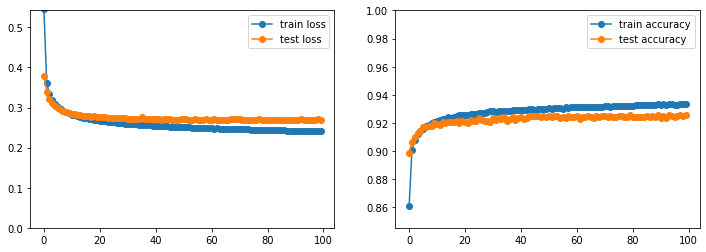

In [25]:
%%time
smodel = make_MLP_model([], None, 0)
smodel, scores = test_model(smodel, train_x, train_y, test_x, test_y,
                           n_epoch=100, batchsize=100, lr=0.1,
                           earlystop=True, verbose=True,
                           save_name="singleLayerPerceptron_100_0.1")

epoch 0 | Train loss 1.198, accuracy 0.7292 | Test loss 0.757, accuracy 0.8377
epoch 1 | Train loss 0.661, accuracy 0.8506 | Test loss 0.581, accuracy 0.8619
epoch 2 | Train loss 0.549, accuracy 0.8664 | Test loss 0.510, accuracy 0.8736
epoch 3 | Train loss 0.495, accuracy 0.8756 | Test loss 0.470, accuracy 0.8809
epoch 4 | Train loss 0.462, accuracy 0.8807 | Test loss 0.444, accuracy 0.8846
epoch 5 | Train loss 0.439, accuracy 0.8851 | Test loss 0.425, accuracy 0.8884
epoch 6 | Train loss 0.422, accuracy 0.8876 | Test loss 0.410, accuracy 0.8925
epoch 7 | Train loss 0.409, accuracy 0.8904 | Test loss 0.398, accuracy 0.8941
epoch 8 | Train loss 0.398, accuracy 0.8930 | Test loss 0.389, accuracy 0.8962
epoch 9 | Train loss 0.389, accuracy 0.8952 | Test loss 0.381, accuracy 0.8981
epoch 10 | Train loss 0.381, accuracy 0.8966 | Test loss 0.374, accuracy 0.8999
epoch 11 | Train loss 0.375, accuracy 0.8984 | Test loss 0.368, accuracy 0.9006
epoch 12 | Train loss 0.369, accuracy 0.8997 | Tes

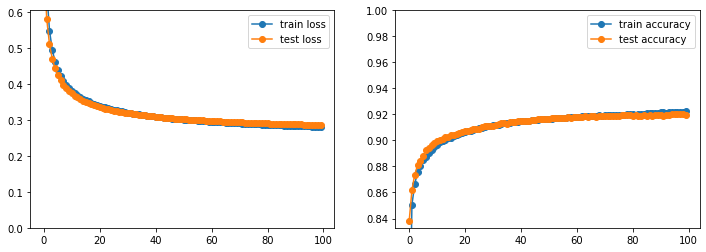

CPU times: user 2min 22s, sys: 45.5 s, total: 3min 8s
Wall time: 1min 55s


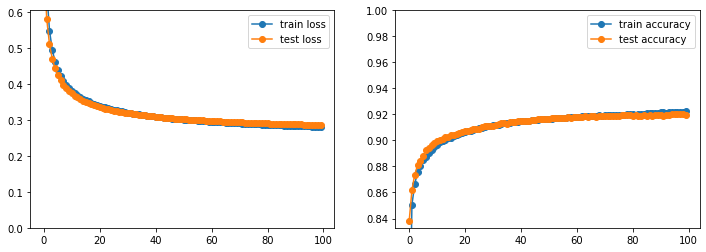

In [26]:
%%time
smodel = make_MLP_model([], None, 0)
smodel, scores = test_model(smodel, train_x, train_y, test_x, test_y,
                           n_epoch=100, batchsize=1000, lr=0.1,
                           earlystop=True, verbose=True,
                           save_name="singleLayerPerceptron_1000_0.1")

epoch 0 | Train loss 1.684, accuracy 0.4510 | Test loss 0.930, accuracy 0.7822
epoch 1 | Train loss 1.649, accuracy 0.4647 | Test loss 0.921, accuracy 0.7686
epoch 2 | Train loss 1.645, accuracy 0.4657 | Test loss 0.927, accuracy 0.7804
epoch 3 | Train loss 1.644, accuracy 0.4665 | Test loss 0.921, accuracy 0.7757
epoch 4 | Train loss 1.643, accuracy 0.4665 | Test loss 0.926, accuracy 0.7756
epoch 5 | Train loss 1.642, accuracy 0.4677 | Test loss 0.916, accuracy 0.7791
epoch 6 | Train loss 1.641, accuracy 0.4671 | Test loss 0.938, accuracy 0.7619
epoch 7 | Train loss 1.641, accuracy 0.4672 | Test loss 0.928, accuracy 0.7730
epoch 8 | Train loss 1.640, accuracy 0.4679 | Test loss 0.927, accuracy 0.7650
epoch 9 | Train loss 1.640, accuracy 0.4673 | Test loss 0.943, accuracy 0.7546
epoch 10 | Train loss 1.640, accuracy 0.4680 | Test loss 0.937, accuracy 0.7494
epoch 11 | Train loss 1.640, accuracy 0.4682 | Test loss 0.933, accuracy 0.7689
epoch 12 | Train loss 1.640, accuracy 0.4681 | Tes

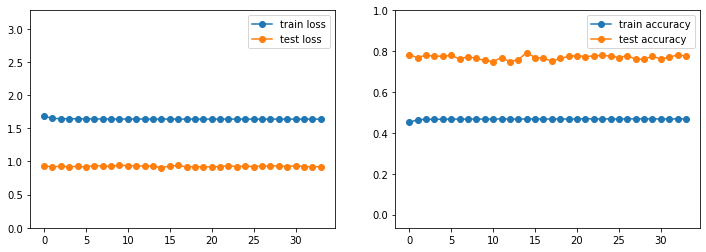

early stopped.
CPU times: user 7min 1s, sys: 2min 45s, total: 9min 46s
Wall time: 5min 45s


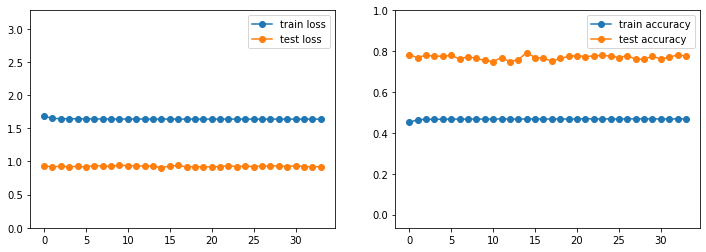

In [15]:
%%time
smodel = make_MLP_model([], None, 0)
new_train_x, new_train_y = augment_images(train_x, train_y, 10)
smodel, scores = test_model(smodel, new_train_x, new_train_y, test_x, test_y,
                           n_epoch=100, batchsize=100, lr=0.1,
                           earlystop=True, verbose=True,
                           save_name="singleLayerPerceptron_1000_0.1_aug10")

epoch 0 | Train loss 1.818, accuracy 0.4039 | Test loss 1.018, accuracy 0.7794
epoch 1 | Train loss 1.694, accuracy 0.4522 | Test loss 0.971, accuracy 0.7822
epoch 2 | Train loss 1.669, accuracy 0.4587 | Test loss 0.958, accuracy 0.7804
epoch 3 | Train loss 1.658, accuracy 0.4623 | Test loss 0.945, accuracy 0.7794
epoch 4 | Train loss 1.652, accuracy 0.4647 | Test loss 0.945, accuracy 0.7818
epoch 5 | Train loss 1.648, accuracy 0.4661 | Test loss 0.942, accuracy 0.7794
epoch 6 | Train loss 1.645, accuracy 0.4667 | Test loss 0.931, accuracy 0.7832
epoch 7 | Train loss 1.643, accuracy 0.4680 | Test loss 0.933, accuracy 0.7821
epoch 8 | Train loss 1.641, accuracy 0.4687 | Test loss 0.932, accuracy 0.7811
epoch 9 | Train loss 1.640, accuracy 0.4687 | Test loss 0.932, accuracy 0.7805
epoch 10 | Train loss 1.639, accuracy 0.4694 | Test loss 0.929, accuracy 0.7834
epoch 11 | Train loss 1.638, accuracy 0.4698 | Test loss 0.934, accuracy 0.7789
epoch 12 | Train loss 1.637, accuracy 0.4702 | Tes

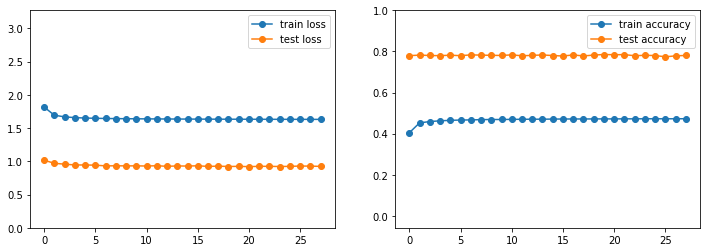

epoch 28 | training...learning interrupted in 28th epoch
CPU times: user 4min 41s, sys: 1min 34s, total: 6min 16s
Wall time: 3min 19s


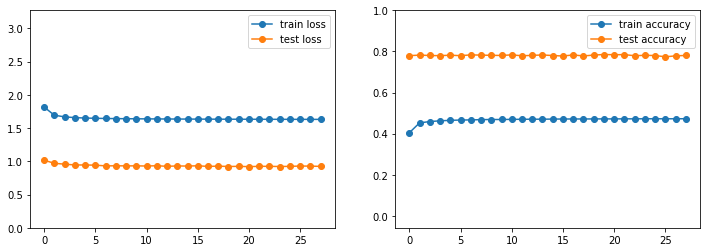

In [16]:
%%time
smodel = make_MLP_model([], None, 0)
#new_train_x, new_train_y = augment_images(train_x, train_y, 10)
smodel, scores = test_model(smodel, new_train_x, new_train_y, test_x, test_y,
                           n_epoch=100, batchsize=1000, lr=0.1,
                           earlystop=True, verbose=True,
                           save_name="singleLayerPerceptron_1000_0.1_aug10")

epoch 0 | Train loss 2.329, accuracy 0.1131 | Test loss 2.212, accuracy 0.1768
epoch 1 | Train loss 2.251, accuracy 0.1603 | Test loss 2.069, accuracy 0.2989
epoch 2 | Train loss 2.194, accuracy 0.2049 | Test loss 1.951, accuracy 0.4090
epoch 3 | Train loss 2.148, accuracy 0.2426 | Test loss 1.852, accuracy 0.5116
epoch 4 | Train loss 2.109, accuracy 0.2729 | Test loss 1.768, accuracy 0.5805
epoch 5 | Train loss 2.076, accuracy 0.2963 | Test loss 1.696, accuracy 0.6243
epoch 6 | Train loss 2.048, accuracy 0.3142 | Test loss 1.635, accuracy 0.6526
epoch 7 | Train loss 2.024, accuracy 0.3275 | Test loss 1.581, accuracy 0.6726
epoch 8 | Train loss 2.003, accuracy 0.3376 | Test loss 1.534, accuracy 0.6859
epoch 9 | Train loss 1.985, accuracy 0.3456 | Test loss 1.494, accuracy 0.6974
epoch 10 | Train loss 1.969, accuracy 0.3520 | Test loss 1.457, accuracy 0.7064
epoch 11 | Train loss 1.954, accuracy 0.3575 | Test loss 1.425, accuracy 0.7139
epoch 12 | Train loss 1.941, accuracy 0.3622 | Tes

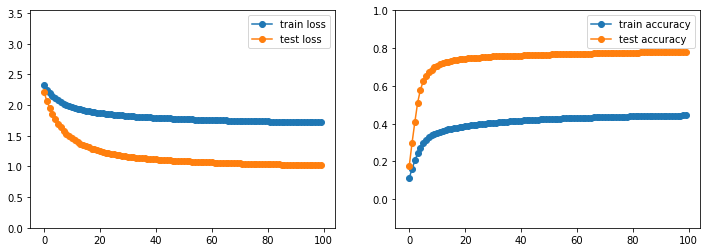

CPU times: user 16min 7s, sys: 5min 23s, total: 21min 31s
Wall time: 11min 25s


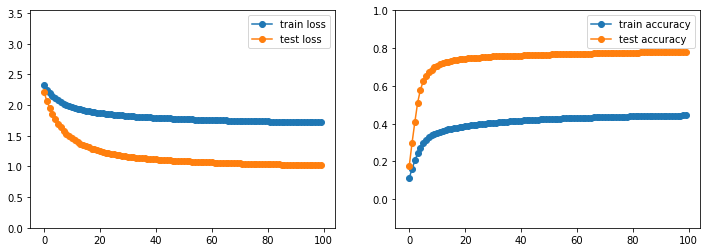

In [17]:
%%time
smodel = make_MLP_model([], None, 0)
#new_train_x, new_train_y = augment_images(train_x, train_y, 10)
smodel, scores = test_model(smodel, new_train_x, new_train_y, test_x, test_y,
                           n_epoch=100, batchsize=1000, lr=0.001,
                           earlystop=True, verbose=True,
                           save_name="singleLayerPerceptron_1000_0.001_aug10")

epoch 0 | Train loss 1.765, accuracy 0.4455 | Test loss 0.852, accuracy 0.8373
epoch 1 | Train loss 1.561, accuracy 0.5129 | Test loss 0.768, accuracy 0.8471
epoch 2 | Train loss 1.515, accuracy 0.5270 | Test loss 0.733, accuracy 0.8523
epoch 3 | Train loss 1.490, accuracy 0.5351 | Test loss 0.717, accuracy 0.8526
epoch 4 | Train loss 1.474, accuracy 0.5406 | Test loss 0.706, accuracy 0.8526
epoch 5 | Train loss 1.462, accuracy 0.5446 | Test loss 0.697, accuracy 0.8561
epoch 6 | Train loss 1.454, accuracy 0.5481 | Test loss 0.694, accuracy 0.8541
epoch 7 | Train loss 1.447, accuracy 0.5502 | Test loss 0.687, accuracy 0.8545
epoch 8 | Train loss 1.441, accuracy 0.5523 | Test loss 0.684, accuracy 0.8537
epoch 9 | Train loss 1.437, accuracy 0.5539 | Test loss 0.681, accuracy 0.8537
epoch 10 | Train loss 1.433, accuracy 0.5551 | Test loss 0.677, accuracy 0.8572
epoch 11 | Train loss 1.430, accuracy 0.5559 | Test loss 0.674, accuracy 0.8537
epoch 12 | Train loss 1.427, accuracy 0.5567 | Tes

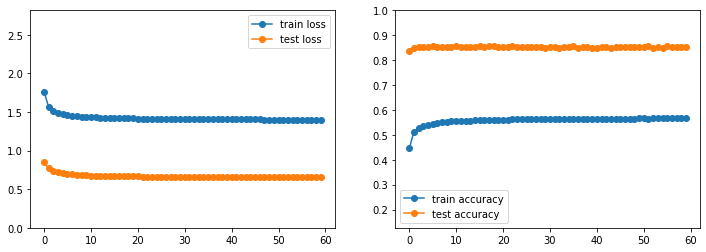

early stopped.
CPU times: user 3min 43s, sys: 1min 9s, total: 4min 52s
Wall time: 2min 50s


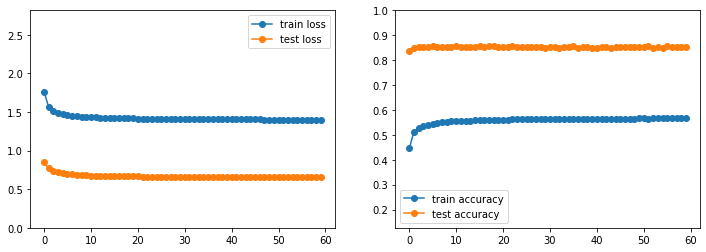

In [18]:
%%time
smodel = make_MLP_model([], None, 0)
new_train_x, new_train_y = augment_images(train_x, train_y, 3)
smodel, scores = test_model(smodel, new_train_x, new_train_y, test_x, test_y,
                           n_epoch=100, batchsize=1000, lr=0.1,
                           earlystop=True, verbose=True,
                           save_name="singleLayerPerceptron_1000_0.1_aug3")

### Cross validation

In [ ]:
#for i in range(5):
i = 1
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=2+42*i)
train_y = np.eye(10)[train_y].astype(np.int32)
test_y = np.eye(10)[test_y].astype(np.int32)
train_n = train_x.shape[0]
test_n = test_x.shape[0]

new_train_x, new_train_y = augment_images(train_x, train_y, 10)

model = make_MLP_model([1000, 1000], Mish, 0.4)

model, scores = test_model(model, new_train_x, new_train_y, test_x, test_y,
                           20, 100, 0.5,
                           earlystop=True, verbose=True, save_name="aug10_Mish_1000x2_0.4_0.5_kfold1")

In [ ]:
class MLPex(MLP_withDropout):
    def predict(self, x):
        self.y = x
        for layer in self.layers:
            if isinstance(layer, Dropout): 
              self.y = layer(self.y, train_flg=False)
            else:
              self.y = layer(self.y)
        return self.y
        
    def test(self, x, t):
        self.predict(x)
        self.loss = np.sum(-t*np.log(self.y + 1e-7)) / len(x)
        return self.loss

In [ ]:
class MLP_Wrapper:
  def __init__(layer_unitsizes, activation_func, dropout_ratio,
               batch_size, learing_ratio, 
               max_epoch, earlystop=False, eps=1e-5,
               verbose=False, save_name=None):
    # モデル設定
    self._layer_unitsizes = layer_unitsizes
    self.activation_func = activaton_func
    self.dropout_ratio = dropout_ratio
    layers = [Linear(784, layer_unitsizes[0], activation_func)]
    for i in range(1, len(layer_unitsizes)):
      layers += [Linear(layer_unitsizes[i-1], layer_unitsizes[i], activation_func)]
    layers += [Linear(layer_unitsizes[-1], 10, Softmax)]
    self.model = MLPex(layers, dropout_ratio)

    # 学習パラメータ設定
    self.batch_size = batch_size
    self.learning_ratio = learning_ratio

    self.max_epoch = max_epoch
    self.earlystop = earlystop
    self.eps = eps
    self.verbose = verbose
    self.save_name = save_name

    return self.model

  # TODO CVをちゃんと実装しよう
  # epochごとにyeildで返して順次処理かな……
  def train(train_x, train_y, magnification=1, include_original=True,
            validation_x, validation_y):
    if self.verbose:
      plt.ion()
      fig = plt.figure(figsize=(12,4))
      ax1 = fig.add_subplot(1, 2, 1)
      ax2 = fig.add_subplot(1, 2, 2)
      outputs = ""
    
    if magnification>1:
      train_x, train_y = augment_images(train_x, train_y, magnification, include_original)
      
    self.lastloss = 10**9
    self.scores = []

    for epoch in range(max_epoch):
      try:
        # train
        if self.verbose:
          print(f"epoch {epoch} | training...", end="")
        sum_loss = 0
        pred_y = []
        perm = np.random.permutation(train_n)      
        for i in range(0, train_n, self.batchsize):
            x = train_x[perm[i: i+self.batchsize]]
            t = train_y[perm[i: i+self.batchsize]]
            sum_loss += self.model.train(x, t, lr) * len(x)
            pred_y.extend(np.argmax(model.y, axis=1))
        
        train_loss = sum_loss / train_n
        train_accuracy = np.sum(np.eye(10)[pred_y] * train_y[perm]) / train_n
        
        # validation
        if self.verbose:
          print(f" | testing...")
        sum_loss = 0
        pred_y = []      
        for i in range(0, test_n, self.batchsize):
            x = test_x[i: i+batchsize]
            t = test_y[i: i+batchsize]
            sum_loss += model.test(x, t) * len(x)
            pred_y.extend(np.argmax(model.y, axis=1))

        test_loss = sum_loss / test_n
        test_accuracy = np.sum(np.eye(10)[pred_y] * test_y) / test_n
        scores += [[train_loss, train_accuracy, test_loss, test_accuracy]]

        yield model, scores

      except KeyboardInterrupt as e:
        # manual stop
        print(f"learning interrupted in {epoch}th epoch")
        break

      # output status
      if verbose:
        outputs += 'epoch %d | ' % epoch
        outputs += 'Test loss %.3f, accuracy %.4f | ' %(train_loss, train_accuracy)
        outputs += f'Test loss {test_loss:.3f}, accuracy {test_accuracy:.4f}\n'

        ax1.cla()
        ax2.cla()
        s = np.array(scores)
        ax1.plot(range(s.shape[0]), s[:,0], marker="o", label="train loss")
        ax1.plot(range(s.shape[0]), s[:,2], marker="o", label="test loss")
        ax1.set_ylim(0, max(s[:,0][s.shape[0]//2:].max(), s[:,2][s.shape[0]//2:].max(), 0.1)*2)
        ax1.legend()
        ax2.plot(range(s.shape[0]), s[:,1], marker="o", label="train accuracy")
        ax2.plot(range(s.shape[0]), s[:,3], marker="o", label="test accuracy")
        ax2.set_ylim(1-(1-min(s[:,1][s.shape[0]//2:].min(), s[:,3][s.shape[0]//2:].min(), 0.95))*2, 1)
        ax2.legend()

        clear_output(wait = True)
        print(outputs.rstrip())
        display(fig) 

      # save current model
      if save_name is not None:
        with open(f"{save_name}.bin", mode="wb") as f:
          pickle.dump((model, scores), f)

      # early stop if loss doesn't update
      if earlystop and abs(lastloss-train_loss)<eps:
        print(f"early stopped.")
        break
      else:
        lastloss = train_loss
      # end epoch
    
    return model, scores
def augment_images(train_x, train_y, magnification, include_original=True):
    new_train_x = []
    new_train_y = []
    for arr,lbl in zip(train_x, train_y):
      if include_original:
        new_train_x.append(arr)
        new_train_y.append(lbl)
      im = Image.fromarray((arr.reshape(28, 28)*2**8//1).astype(np.uint8), "L")
      for _ in range((magnification-1) if include_original else magnification):
        z = 0.8+np.random.rand()*0.4
        t, x, y = (np.random.randint(-5,6,size=3)/1.2//1).astype(np.int)
        newim = np.asarray(zoom_at(im, 28//2, 28//2, z).rotate(t, translate=(x, y))).ravel()/2**8
        new_train_x.append(newim)
        new_train_y.append(lbl)
    new_train_x = np.asarray(new_train_x)
    new_train_y = np.asarray(new_train_y)
    return new_train_x, new_train_y